<a href="https://colab.research.google.com/github/EVA6-Group-15/CIFAR_85/blob/master/notebooks/CIFAR10_01_MaxPooled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory Information

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.46GB
Available: 24.56GB
Used: 570.95MB
Percentage: 3.5%


In [ ]:
! nvidia-smi

Fri Jun 18 13:43:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Module Imports

## Clone DLUtils repo

In [ ]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git ./DLUtils
!cp -r ./DLUtils/src/dlutils/ ./utils

Cloning into './DLUtils'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 231 (delta 95), reused 146 (delta 49), pack-reused 0
Receiving objects: 100% (231/231), 55.29 KiB | 11.06 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
!rm -r DLUtils

## Install Albumentations

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

In [ ]:
from utils.data.pytorch_data import GetData
from utils.data.transformations import * #HELPER, generate_compose
from utils.visualization import plot_inference, plotter

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [ ]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")

LOADER_kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
cifar = GetData('CIFAR10')

# Download Data and perform Data Transforms

In [ ]:
train_data = cifar.build_data(train=True)
test_data = cifar.build_data(train=False)

In [ ]:
loader = DataLoader(
    train_data,
    batch_size=1000,
    num_workers=1,
    shuffle=False
)

mean, std = plotter.data_stats(loader)

Train Statistics
Image Shape:  torch.Size([3, 32, 32])
 - mean: [tensor(0.4914), tensor(0.4822), tensor(0.4465)]
 - std: [tensor(0.2470), tensor(0.2434), tensor(0.2615)]


In [ ]:
trans = generate_compose(mean, std) #Normalize and ToTensor by Default

In [ ]:
train_data = cifar.build_data(trans, train=True)
test_data = cifar.build_data(trans, train=False)
train_loader = cifar.build_loader(train_data, 64, **LOADER_kwargs)
test_loader = cifar.build_loader(test_data, 64, **LOADER_kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = train_data.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Visualization of transformed data

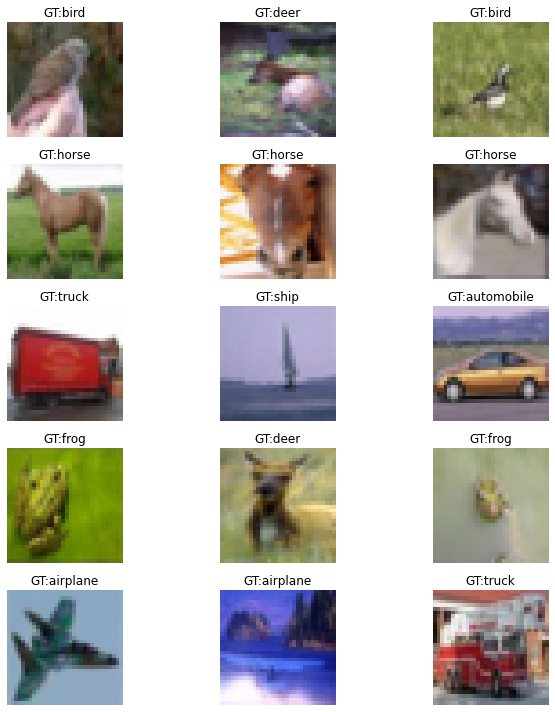

In [ ]:
from utils.visualization import plot_inference, plotter
plotter.plot_data_grid(train_loader, mean= mean, std= std, class_list=classes, ncol=3,nrow=5)

# Model Architecture

In [ ]:
from utils.models.CIFAR10.model_MaxPool import Net

In [ ]:
model = Net().to(DEVICE)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,608
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 16, 16, 16]             512
       BatchNorm2d-9           [-1, 16, 16, 16]              32
             ReLU-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 64,

In [ ]:
from utils.features.runner import run

## Model Training

In [ ]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
ai = run.Run(model, train_loader, test_loader, 50, DEVICE, optimizer)
ai()

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1


loss=0.9630638957023621 batch_id=781: 100%|██████████| 782/782 [00:11<00:00, 67.69it/s]


TRAIN set: Average loss: 1.4710, Train Accuracy: 44.79% | TEST set: Average loss: 1.1259, Test Accuracy: 58.57%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 1.0165, Train Accuracy: 63.59% | TEST set: Average loss: 0.9293, Test Accuracy: 67.02%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.8434, Train Accuracy: 70.02% | TEST set: Average loss: 0.9181, Test Accuracy: 68.19%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.7329, Train Accuracy: 74.08% | TEST set: Average loss: 0.8091, Test Accuracy: 72.01%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.6564, Train Accuracy: 76.95% | TEST set: Average loss: 0.6768, Test Accuracy: 76.66%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.5978, Train Accuracy: 79.12% | TEST set: Average loss: 0.7602, Test Accur

# Outputs

In [ ]:
print('Train Accuracy:', max(ai.metrics['train_accuracy']))
print('Test Accuracy:', max(ai.metrics['test_accuracy']))

Train Accuracy: 97.022
Test Accuracy: 79.67


## Accuracy and Loss Plots

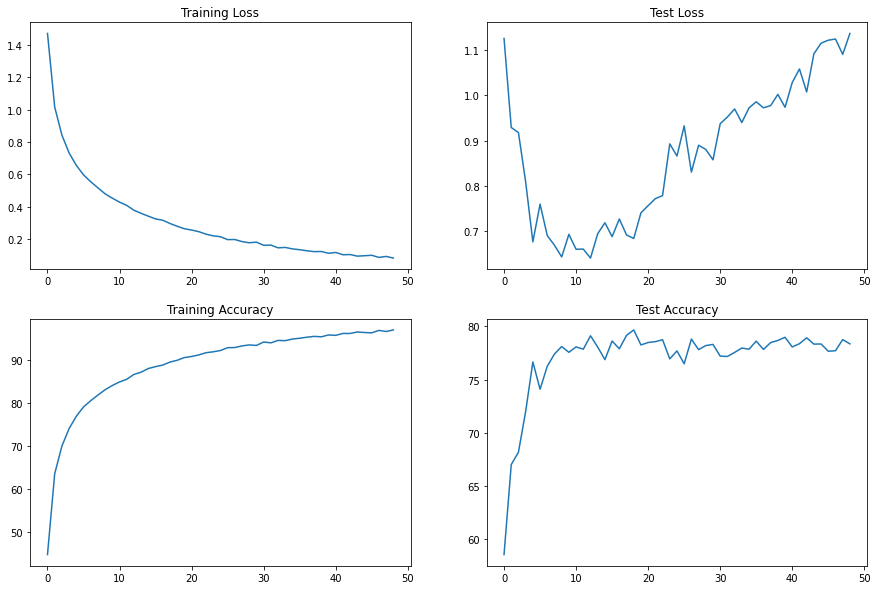

In [ ]:
plotter.plot_loss_acc(ai.metrics['train_loss'], ai.metrics['train_accuracy'], ai.metrics['test_loss'], ai.metrics['test_accuracy'])

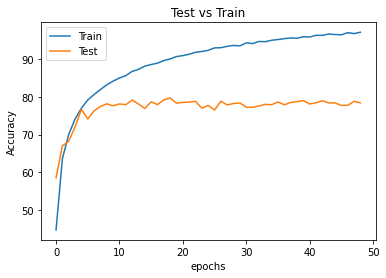

In [ ]:
plotter.plot_combined([ai.metrics['train_accuracy'], ai.metrics['test_accuracy']])

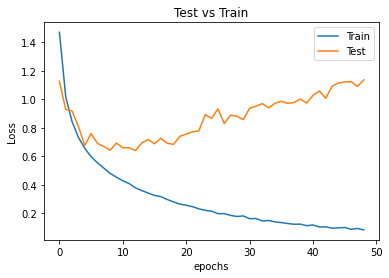

In [ ]:
plotter.plot_combined([ai.metrics['train_loss'], ai.metrics['test_loss']], y_label='Loss')

In [ ]:
results = plot_inference.Results(model, test_loader, DEVICE, mean, std, classes)

## Correctly predicted images

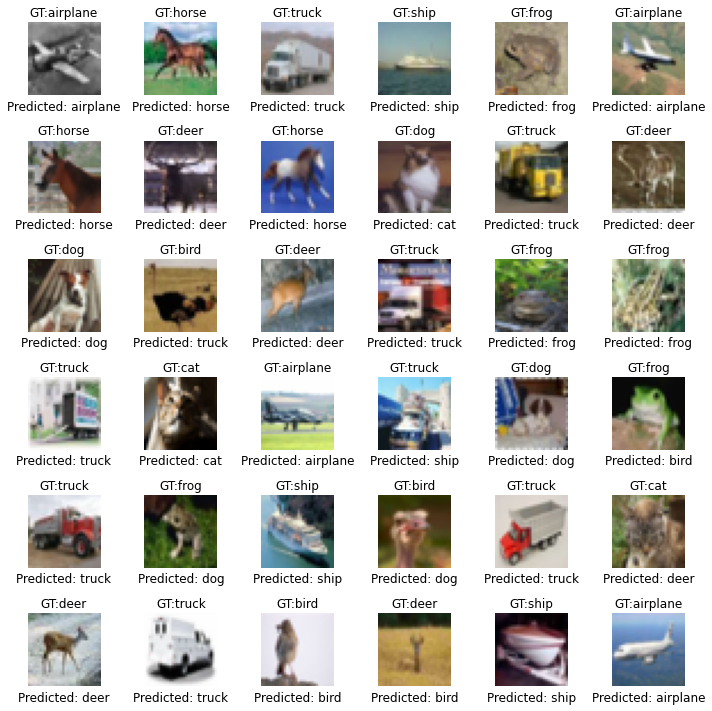

In [ ]:
results.plot_batch(6,6)

## Incorrect Predictions

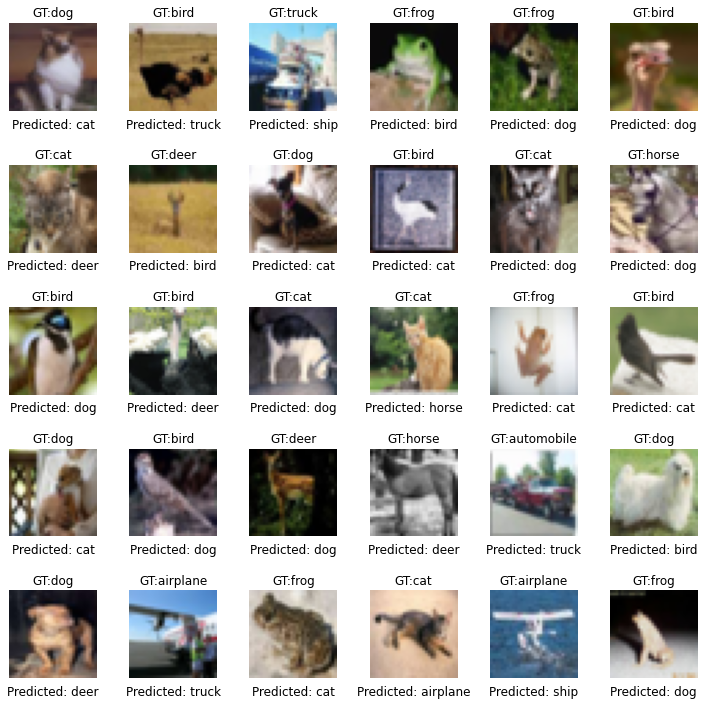

In [ ]:
results.plot_incorrect(5,6)

## Confusion Matrix

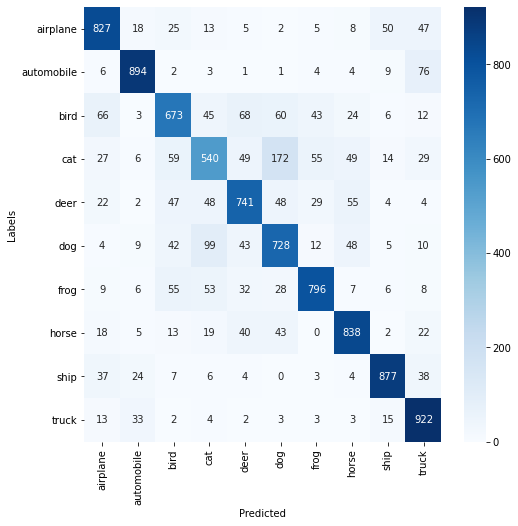

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class cat is 54.00
Accuracy of class bird is 67.30
Accuracy of class dog is 72.80
Accuracy of class deer is 74.10
Accuracy of class frog is 79.60
Accuracy of class airplane is 82.70
Accuracy of class horse is 83.80
Accuracy of class ship is 87.70
Accuracy of class automobile is 89.40
Accuracy of class truck is 92.20


In [ ]:
results.class_accuracy()